# Imports

In [1]:
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_score,recall_score,roc_auc_score,accuracy_score,classification_report,f1_score

# Data Reading and Exploration

In [9]:
df_1 = pd.read_csv('../data/raw/log1.csv')
df_2 = pd.read_csv('../data/raw/log2.csv')
df = pd.concat([df_1, df_2], axis=0)
df.shape

(6362620, 11)

### **🔍 Column-by-Column Explanation**
| Column | Description | Fraud Relevance | Example |
|--------|-------------|-----------------|---------|
| **`step`** | Time in hours (1-744 = 30 days). | Fraudsters often act in **short bursts** (e.g., rapid transfers in 1-2 hours). | `37` = Hour 37 |
| **`type`** | Transaction type: `CASH_IN`, `CASH_OUT`, `DEBIT`, `PAYMENT`, `TRANSFER`. | **`CASH_OUT` + `TRANSFER`** are most fraud-prone (to steal funds). | `CASH_OUT` |
| **`amount`** | Transaction value. | Large amounts (e.g., >`200K`) may trigger fraud flags. | `218436.58` |
| **`nameOrig`** | Sender’s ID (C = customer, M = merchant). | Customers starting new transactions suddenly. | `C1929902580` |
| **`oldbalanceOrg`** | Sender’s balance **before** transaction. | Sudden **large transfers** from low-balance accounts. | `986562.69` |
| **`newbalanceOrig`** | Sender’s balance **after** transaction. | Emptying accounts (`newbalance ≈ 0`) is suspicious. | `1204999.27` |
| **`nameDest`** | Recipient’s ID. | **New recipients** (never interacted with sender) are risky. | `C1573676608` |
| **`oldbalanceDest`** | Recipient’s balance **before** transaction. | Merchants (`M*`) lack balance data → harder to trace. | `221269.02` |
| **`newbalanceDest`** | Recipient’s balance **after** transaction. | Rapid balance spikes may indicate layering. | `2832.44` |
| **`isFraud`** | `1` = Fraudulent transaction (target variable). | Only **0.1%** are fraud → **class imbalance**. | `0` |
| **`isFlaggedFraud`** | `1` = Flagged by system (transfers >$200K). | **Too simplistic** (misses small, rapid fraud). | `0` |





In [14]:
display(df.sample(7))

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2875565,227,PAYMENT,15340.39,C2044697881,0.00,0.00,M1733605492,0.00,0.00,0,0
2694491,211,CASH_OUT,118919.95,C2037748640,0.00,0.00,C391318560,164437.90,283357.85,0,0
4799161,345,PAYMENT,8677.92,C277730450,0.00,0.00,M2020706462,0.00,0.00,0,0
1354750,137,CASH_IN,186342.43,C666702604,30078.00,216420.43,C1014089638,227841.68,41499.25,0,0
4735456,332,CASH_OUT,91124.86,C1536180655,0.00,0.00,C1303498195,4775912.88,4867037.74,0,0
3228334,250,PAYMENT,86593.23,C342224337,175443.58,88850.35,M1546763219,0.00,0.00,0,0
5511518,380,CASH_OUT,158944.55,C1774439611,0.00,0.00,C1572468807,3780184.89,3939129.44,0,0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [16]:
print('Number of Transactions:',df.shape[0])

Number of Transactions: 6362620


In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00


In [18]:
df.duplicated().sum()

np.int64(0)

In [19]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

no missing and duplicate values in the dataset.

# Exploratory Data Analysis

In [20]:
df['isFraud'].value_counts(normalize=True)

isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64

highly imbalanced dataset

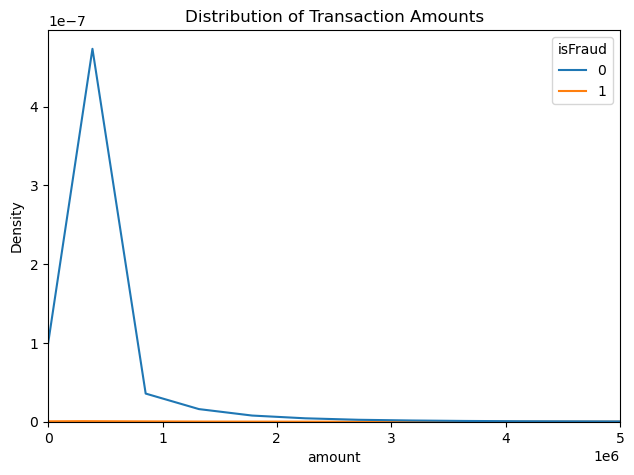

In [21]:
sns.kdeplot(df,x='amount', hue='isFraud')
plt.tight_layout()
plt.title('Distribution of Transaction Amounts')
plt.xlim(0, 5000000)
plt.show()

very low density of fraud cases

In [22]:
df['type'].value_counts().sort_values(ascending=False)

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

/tmp/ipykernel_13316/1193271039.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df,x='type',palette='viridis',order=df["type"].value_counts().index)


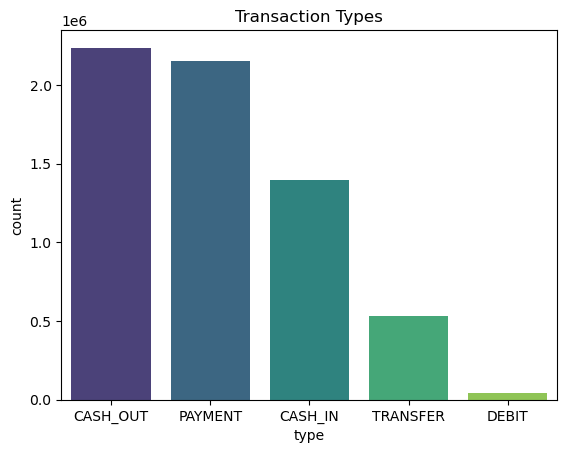

In [23]:
sns.countplot(data=df,x='type',palette='viridis',order=df["type"].value_counts().index)
plt.title('Transaction Types')
plt.show()

Most transactions are Cash Out and least transactions are Payment.

In [24]:
df.groupby(['type', 'isFraud']).size().unstack().apply(lambda x: x / x.sum(), axis=1)

isFraud,0,1
type,,
CASH_IN,1.000000,NaN
CASH_OUT,0.998160,0.001840
DEBIT,1.000000,NaN
PAYMENT,1.000000,NaN
TRANSFER,0.992312,0.007688


In [25]:
df.groupby(['type', 'isFraud']).size().unstack().apply(lambda x: x / x.sum(), axis=0)

isFraud,0,1
type,,
CASH_IN,0.220207,NaN
CASH_OUT,0.351470,0.501157
DEBIT,0.006520,NaN
PAYMENT,0.338583,NaN
TRANSFER,0.083220,0.498843


most fraud cases are Cash Out and Transfer also which are very low.

<Axes: xlabel='type', ylabel='count'>

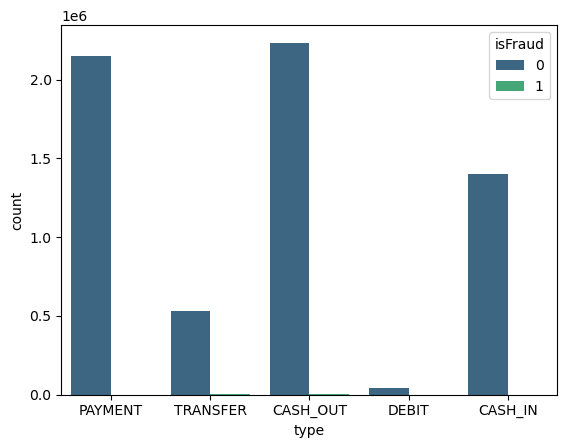

In [26]:
sns.countplot(data=df,x='type',hue='isFraud',palette='viridis')

In [27]:
df.corr(numeric_only=True)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.003277
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,0.012295
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.003835
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.003776
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,-0.000513
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,-0.000529
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,0.044109
isFlaggedFraud,0.003277,0.012295,0.003835,0.003776,-0.000513,-0.000529,0.044109,1.000000


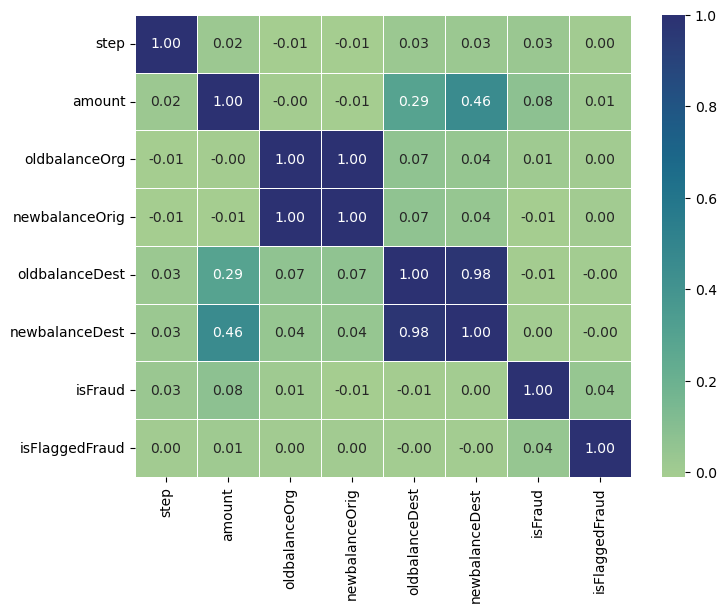

In [28]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(numeric_only=True),cmap='crest',annot=True, fmt='.2f',linewidths=0.5)
plt.show()

In [29]:
x = df.corr(numeric_only=True)
x[x>0.7]

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amount,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
oldbalanceOrg,NaN,NaN,1.000000,0.998803,NaN,NaN,NaN,NaN
newbalanceOrig,NaN,NaN,0.998803,1.000000,NaN,NaN,NaN,NaN
oldbalanceDest,NaN,NaN,NaN,NaN,1.000000,0.976569,NaN,NaN
newbalanceDest,NaN,NaN,NaN,NaN,0.976569,1.000000,NaN,NaN
isFraud,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
isFlaggedFraud,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


* `newbalanceOrig` and `oldbalanceOrg` are highly correlated.
* `oldbalanceDest` and `newbalanceDest` are also highly correlated.

# Data Pre-Processing

No null nor any duplicates.

In [30]:
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_lower = df[df[column] < lower_bound]
    outliers_upper= df[df[column] > upper_bound]
    return outliers_upper.shape[0], outliers_lower.shape[0]

In [31]:
outliers_upper_count,outliers_lower_count = detect_outliers(df, 'amount')
print(outliers_upper_count,outliers_lower_count)

338078 0


<Axes: xlabel='amount'>

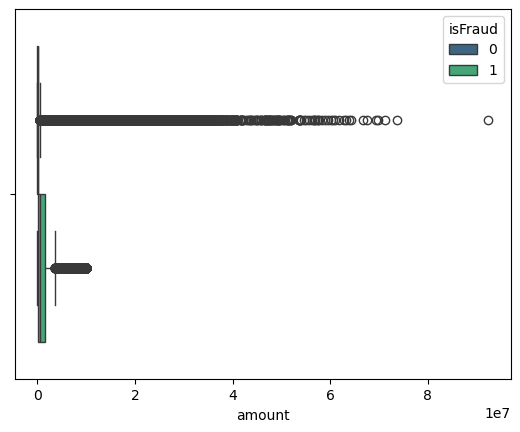

In [32]:
sns.boxplot(data=df, x='amount', hue='isFraud', palette='viridis')

## Feature Engineering and Selection

In [33]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [3]:
df['transactionType'] = df['nameOrig'].str[0] + df['nameDest'].str[0]

In [4]:
df['net_sender'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['net_receiver'] = df['newbalanceDest'] - df['oldbalanceDest']

removing isFlaggedFraud column because it has very less correlation with isFraud

In [5]:
df=df.drop(['nameOrig','nameDest',"isFlaggedFraud"],axis=1)

In [15]:
df

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,transactionType,net_sender,net_receiver
0,1,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0,CM,9839.64,0.00
1,1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0,CM,1864.28,0.00
2,1,TRANSFER,181.00,181.00,0.00,0.00,0.00,1,CC,181.00,0.00
3,1,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1,CC,181.00,-21182.00
4,1,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0,CM,11668.14,0.00
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,339682.13,0.00,0.00,339682.13,1,CC,339682.13,339682.13
6362616,743,TRANSFER,6311409.28,6311409.28,0.00,0.00,0.00,1,CC,6311409.28,0.00
6362617,743,CASH_OUT,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,CC,6311409.28,6311409.27
6362618,743,TRANSFER,850002.52,850002.52,0.00,0.00,0.00,1,CC,850002.52,0.00


In [7]:
df['transactionType'].unique()

array(['CM', 'CC'], dtype=object)

In [39]:
df.corr(numeric_only=True)['isFraud'].sort_values(ascending=False)

isFraud           1.000000
net_sender        0.362472
amount            0.076688
step              0.031578
net_receiver      0.027028
oldbalanceOrg     0.010154
newbalanceDest    0.000535
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
Name: isFraud, dtype: float64

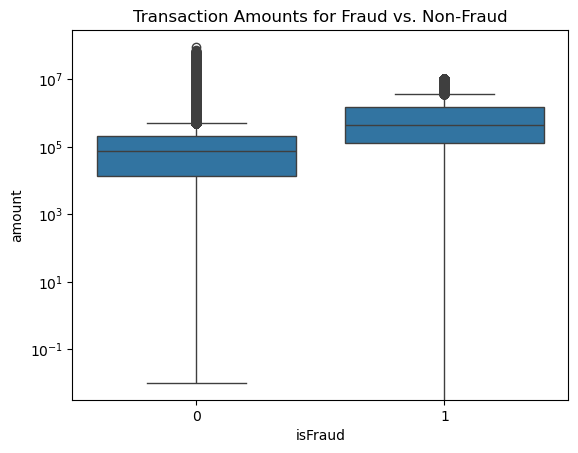

In [40]:
sns.boxplot(x="isFraud", y="amount", data=df)
plt.title("Transaction Amounts for Fraud vs. Non-Fraud")
plt.yscale('log') # Log scale helps visualize high-value transactions
plt.show()

# Encoding

In [57]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,transactionType,net_sender,net_receiver
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,CM,9839.64,0.0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,CM,1864.28,0.0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,CC,181.00,0.0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,CC,181.00,-21182.0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,CM,11668.14,0.0


In [7]:
from sklearn.preprocessing import OneHotEncoder

# Select categorical columns
categorical_cols = ['transactionType', 'type']

# Initialize encoder
ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)

# Fit and transform
encoder = ohe.fit_transform(df[categorical_cols])

# Get new column names
encoded_cols = ohe.get_feature_names_out(categorical_cols)

In [8]:
encoded_cols

array(['transactionType_CM', 'type_CASH_OUT', 'type_DEBIT',
       'type_PAYMENT', 'type_TRANSFER'], dtype=object)

In [9]:
# Create DataFrame from encoded data
encoded_df = pd.DataFrame(encoder, columns=encoded_cols, index=df.index)

# Drop original categorical columns and concatenate
df_encoded = pd.concat([df.drop(categorical_cols, axis=1), encoded_df], axis=1)

In [10]:
df_encoded

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,net_sender,net_receiver,transactionType_CM,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.00,160296.36,0.00,0.00,0,9839.64,0.00,1.0,0.0,0.0,1.0,0.0
1,1,1864.28,21249.00,19384.72,0.00,0.00,0,1864.28,0.00,1.0,0.0,0.0,1.0,0.0
2,1,181.00,181.00,0.00,0.00,0.00,1,181.00,0.00,0.0,0.0,0.0,0.0,1.0
3,1,181.00,181.00,0.00,21182.00,0.00,1,181.00,-21182.00,0.0,1.0,0.0,0.0,0.0
4,1,11668.14,41554.00,29885.86,0.00,0.00,0,11668.14,0.00,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,339682.13,0.00,0.00,339682.13,1,339682.13,339682.13,0.0,1.0,0.0,0.0,0.0
6362616,743,6311409.28,6311409.28,0.00,0.00,0.00,1,6311409.28,0.00,0.0,0.0,0.0,0.0,1.0
6362617,743,6311409.28,6311409.28,0.00,68488.84,6379898.11,1,6311409.28,6311409.27,0.0,1.0,0.0,0.0,0.0
6362618,743,850002.52,850002.52,0.00,0.00,0.00,1,850002.52,0.00,0.0,0.0,0.0,0.0,1.0


# Train Test Split

In [11]:
df2 = df_encoded.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'], axis=1)

In [22]:
df2.to_csv('../data/processed/cleaned.csv', index=False)

In [12]:
fraud = df2[df2["isFraud"] == 1]
non_fraud = df2[df2["isFraud"] == 0].sample(n=60*len(fraud), random_state=42)

# Combine fraud and non-fraud samples
df3 = pd.concat([fraud, non_fraud])
df3 = df3.sample(frac=1, random_state=42).reset_index(drop=True)

In [24]:
df3.head()

,step,amount,isFraud,net_sender,net_receiver,transactionType_CM,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,324,7935.47,0,7935.47,0.00,1.0,0.0,0.0,1.0,0.0
1,298,18710.21,0,18710.21,0.00,1.0,0.0,0.0,1.0,0.0
2,281,240842.33,0,0.00,240842.33,0.0,1.0,0.0,0.0,0.0
3,158,5559.75,0,0.00,0.00,1.0,0.0,0.0,1.0,0.0
4,17,7775.48,0,7775.48,0.00,1.0,0.0,0.0,1.0,0.0


In [13]:
x = df3.drop("isFraud",axis=1)
y = df3["isFraud"]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [26]:
y.value_counts()

isFraud
0    492780
1      8213
Name: count, dtype: int64

In [27]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [28]:
y_train.value_counts()

isFraud
0    394163
1      6631
Name: count, dtype: int64

In [24]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=5000),
    "SGD Classifier": SGDClassifier(n_jobs=-1),
    #"Support Vector Classifier": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(eval_metric="logloss"),
    "CatBoost": CatBoostClassifier(verbose=0),
    "LightGBM": LGBMClassifier(n_jobs=-1)
}   
results= []    

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"Classification Report for {name}:\n")
    print(classification_report(y_test, y_pred))

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    })

Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     98617
           1       0.90      0.64      0.75      1582

    accuracy                           0.99    100199
   macro avg       0.95      0.82      0.87    100199
weighted avg       0.99      0.99      0.99    100199

Classification Report for SGD Classifier:

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     98617
           1       0.31      0.71      0.43      1582

    accuracy                           0.97    100199
   macro avg       0.65      0.84      0.71    100199
weighted avg       0.98      0.97      0.98    100199

Classification Report for Decision Tree:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98617
           1       0.84      0.84      0.84      1582

    accuracy                           1.00    10

In [25]:
summary=pd.DataFrame(results)
summary=summary.reindex()
summary.sort_values(by='Recall',ascending=False)

,Model,Accuracy,Precision,Recall,ROC-AUC,F1-Score
8,CatBoost,0.996986,0.947552,0.856511,0.927875,0.899734
2,Decision Tree,0.995050,0.844981,0.840708,0.919117,0.842839
7,XGBoost,0.996517,0.932632,0.840076,0.919551,0.883937
4,Random Forest,0.996447,0.937233,0.830594,0.914851,0.880697
9,LightGBM,0.996347,0.930595,0.830594,0.914800,0.877756
5,Gradient Boosting,0.996228,0.954683,0.798989,0.899190,0.869924
1,SGD Classifier,0.970149,0.307145,0.709229,0.841782,0.428653
3,K-Nearest Neighbors,0.993503,0.900258,0.661820,0.830322,0.762842
0,Logistic Regression,0.993283,0.903283,0.643489,0.821192,0.751569
6,AdaBoost,0.992156,0.883430,0.579646,0.789210,0.700000


Catboost working best for this dataset with 0.89 f1 score.

### trying smote too

In [31]:
df2 = pd.read_csv("../data/processed/cleaned_data.csv")

In [14]:
df2

,step,amount,isFraud,net_sender,net_receiver,transactionType_CM,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,0,9839.64,0.00,1.0,0.0,0.0,1.0,0.0
1,1,1864.28,0,1864.28,0.00,1.0,0.0,0.0,1.0,0.0
2,1,181.00,1,181.00,0.00,0.0,0.0,0.0,0.0,1.0
3,1,181.00,1,181.00,-21182.00,0.0,1.0,0.0,0.0,0.0
4,1,11668.14,0,11668.14,0.00,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,1,339682.13,339682.13,0.0,1.0,0.0,0.0,0.0
6362616,743,6311409.28,1,6311409.28,0.00,0.0,0.0,0.0,0.0,1.0
6362617,743,6311409.28,1,6311409.28,6311409.27,0.0,1.0,0.0,0.0,0.0
6362618,743,850002.52,1,850002.52,0.00,0.0,0.0,0.0,0.0,1.0


In [15]:
fraud = df2[df2["isFraud"] == 1]
non_fraud = df2[df2["isFraud"] == 0]

fraud.shape, non_fraud.shape

((8213, 10), (6354407, 10))

not applyimng smote on full data as it is highly imbalanced and will take a lot of time to run.

In [16]:
len(non_fraud) / len(fraud)

773.7010836478753

In [17]:
from imblearn.combine import SMOTETomek


non_fraud_sample = non_fraud.sample(n=10*len(fraud), random_state=42)  # 8:1 ratio

df_balanced = pd.concat([fraud, non_fraud_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

x2 = df_balanced.drop("isFraud", axis=1)
y2 = df_balanced["isFraud"]

print(y2.value_counts())
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.2, random_state=42, stratify=y2, shuffle=True)

# 4. Apply SMOTEtomek
print("Before SMOTE:", np.bincount(y_train2))
hybrid = SMOTETomek(sampling_strategy=0.8, random_state=42)  # 80% fraud to non-fraud ratio
x_train2, y_train2 = hybrid.fit_resample(x_train2, y_train2)

print("After SMOTE:", np.bincount(y_train2))

isFraud
0    82130
1     8213
Name: count, dtype: int64
Before SMOTE: [65704  6570]
After SMOTE: [64529 51388]


In [96]:
51977 / 65118

0.7981971190761387

In [97]:
51388/64529

0.7963551271521332

In [18]:
y_train2.value_counts(normalize=True)

isFraud
0    0.556683
1    0.443317
Name: proportion, dtype: float64

In [19]:
scaler=StandardScaler()
x_train2=scaler.fit_transform(x_train2)
x_test2=scaler.transform(x_test2)

In [20]:
models2 = {
    "Logistic Regression": LogisticRegression(max_iter=5000),
    "SGD Classifier": SGDClassifier(n_jobs=-1),
    #"Support Vector Classifier": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(eval_metric="logloss"),
    "CatBoost": CatBoostClassifier(verbose=0),
    "LightGBM": LGBMClassifier(n_jobs=-1)
}   
results2= []    

for name, model in models2.items():
    model.fit(x_train2, y_train2)
    y_pred = model.predict(x_test2)
    
    print(f"Classification Report for {name}:\n")
    print(classification_report(y_test2, y_pred))

    results2.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test2, y_pred),
        'Precision': precision_score(y_test2, y_pred),
        'Recall': recall_score(y_test2, y_pred),
        'ROC-AUC': roc_auc_score(y_test2, y_pred),
        'F1-Score': f1_score(y_test2, y_pred)
    })

Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.99      0.96      0.98     16426
           1       0.72      0.93      0.81      1643

    accuracy                           0.96     18069
   macro avg       0.86      0.95      0.89     18069
weighted avg       0.97      0.96      0.96     18069

Classification Report for SGD Classifier:

              precision    recall  f1-score   support

           0       0.99      0.96      0.98     16426
           1       0.71      0.92      0.80      1643

    accuracy                           0.96     18069
   macro avg       0.85      0.94      0.89     18069
weighted avg       0.97      0.96      0.96     18069

Classification Report for Decision Tree:

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     16426
           1       0.82      0.93      0.87      1643

    accuracy                           0.98     1

/home/naman/miniforge3/envs/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [21]:
summary2=pd.DataFrame(results2)
summary2=summary2.reindex()
summary2.sort_values(by='F1-Score',ascending=False)

,Model,Accuracy,Precision,Recall,ROC-AUC,F1-Score
7,XGBoost,0.976645,0.811004,0.968959,0.973187,0.882973
4,Random Forest,0.977199,0.832883,0.937310,0.959249,0.882016
9,LightGBM,0.974874,0.794745,0.975654,0.975225,0.875956
8,CatBoost,0.974542,0.793840,0.972611,0.973673,0.874179
2,Decision Tree,0.975206,0.818327,0.934875,0.957058,0.872727
3,K-Nearest Neighbors,0.971553,0.775500,0.967133,0.969564,0.860780
5,Gradient Boosting,0.967403,0.745345,0.974437,0.970568,0.844632
0,Logistic Regression,0.960429,0.717228,0.932441,0.947835,0.810797
1,SGD Classifier,0.957662,0.706103,0.915399,0.938644,0.797244
6,AdaBoost,0.947645,0.641494,0.961656,0.953950,0.769605


seems like overfitting is happening here after using smote. so using original data without smote.


In [22]:
summary2.sort_values(by='F1-Score',ascending=False).iloc[0]

Model         XGBoost
Accuracy     0.976645
Precision    0.811004
Recall       0.968959
ROC-AUC      0.973187
F1-Score     0.882973
Name: 7, dtype: object

In [26]:
summary.sort_values(by='F1-Score',ascending=False).iloc[0]

Model        CatBoost
Accuracy     0.996986
Precision    0.947552
Recall       0.856511
ROC-AUC      0.927875
F1-Score     0.899734
Name: 8, dtype: object

- For fraud detection, recall and F1-score are more important than accuracy, because missing frauds (false negatives) is costly.
- XGBoost is the better choice here, as it catches more frauds and has the best balance between precision and recall (highest F1-score).

In [8]:
df_temp1 = pd.read_csv("../data/processed/cleaned_data.csv")
df_temp2 = pd.read_csv("../data/processed/cleaned.csv")

df_temp1.equals(df_temp2)

True

In [ ]:
import pandas as pd

In [2]:
df_temp1 = pl.read_csv("../data/processed/cleaned_data.csv")
df_temp2 = pl.read_csv("../data/processed/cleaned.csv")

In [3]:
df_temp1.equals(df_temp2)

True

In [33]:
df2 = df3.copy()
fraud = df2[df2["isFraud"] == 1]
non_fraud = df2[df2["isFraud"] == 0]

fraud.shape, non_fraud.shape
from imblearn.combine import SMOTETomek


non_fraud_sample = non_fraud.sample(n=10*len(fraud), random_state=42)  # 8:1 ratio

df_balanced = pd.concat([fraud, non_fraud_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

x2 = df_balanced.drop("isFraud", axis=1)
y2 = df_balanced["isFraud"]

print(y2.value_counts())
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.2, random_state=42, stratify=y2, shuffle=True)

# 4. Apply SMOTEtomek
print("Before SMOTE:", np.bincount(y_train2))
hybrid = SMOTETomek(sampling_strategy=0.8, random_state=42)  # 80% fraud to non-fraud ratio
x_train2, y_train2 = hybrid.fit_resample(x_train2, y_train2)

print("After SMOTE:", np.bincount(y_train2))

scaler=StandardScaler()
x_train2=scaler.fit_transform(x_train2)
x_test2=scaler.transform(x_test2)

isFraud
0    82130
1     8213
Name: count, dtype: int64
Before SMOTE: [65704  6570]
After SMOTE: [64457 51316]


In [34]:
model = XGBClassifier(eval_metric="logloss")
model.fit(x_train2, y_train2)
y_pred = model.predict(x_test2)
    
print(f"Classification Report for :\n", classification_report(y_test2, y_pred))


Classification Report for :
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     16426
           1       0.80      0.97      0.88      1643

    accuracy                           0.98     18069
   macro avg       0.90      0.97      0.93     18069
weighted avg       0.98      0.98      0.98     18069



In [49]:
df3.shape

(500993, 10)

In [48]:
df_temp1.shape

(6362620, 10)